## Import Libraries

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr


## function to detect black rectangles

In [2]:
import cv2
import numpy as np

def detect_black_rectangles(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, black_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)
    black_contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []
    for contour in black_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        rectangles.append((x, y, w, h))

    return image, rectangles


## function to detect white circles within black rectangles

In [82]:
import cv2
import numpy as np

def detect_white_circles_in_black_boxes(image, rectangles):
    for (x, y, w, h) in rectangles:
        roi = image[y:y + h, x:x + w]
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, white_mask = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

            if len(approx) > 5:
                area = cv2.contourArea(contour)
                if area > 10:
                    ((x_c, y_c), radius) = cv2.minEnclosingCircle(contour)
                    if 5 < radius < 15:
                        cv2.circle(roi, (int(x_c), int(y_c)), int(radius), (0, 255, 0), 2)

                        # Add text "circle" on top of the detected circle
                        cv2.putText(roi, "circle", (int(x_c) - 20, int(y_c)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        image[y:y + h, x:x + w] = roi

    return image


## function to detect qR codes within black rectangles

In [4]:
def detect_qr_code_manually(image):
    # No need to load the image again, it's already passed as a matrix

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise and improve detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use thresholding to convert the image to binary
    _, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    qr_code_contour = None
    for cnt in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        
        # Check if the polygon has 4 corners (quadrilateral)
        if len(approx) == 4:
            # Calculate the bounding rectangle for the quadrilateral
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            
            # Ensure it is roughly a square (aspect ratio close to 1)
            if 0.9 <= aspect_ratio <= 1.1:
                # Optionally, filter further based on size (QR codes are usually larger)
                area = cv2.contourArea(cnt)
                if area > 1000:  # Adjust this threshold based on the size of your QR code
                    qr_code_contour = approx
                    cv2.drawContours(image, [qr_code_contour], -1, (0, 255, 0), 2)
                    
                    # Write "QR" at the top-left of the bounding box
                    cv2.putText(image, "QR", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    print(f"QR Code detected at: x={x}, y={y}, w={w}, h={h}")
                    break

    # Return the image and the contour (or None if not found)
    return image, qr_code_contour


## function to detect text within black rectangles

In [77]:
def detect_text_and_draw_boxes(image, rectangles, mask=None, confidence_threshold=0.7, min_text_height=50, max_text_height=100):
    reader = easyocr.Reader(['en'])
    
    for (x, y, w, h) in rectangles:
        roi = image[y:y + h, x:x + w]

        if mask is not None:
            masked_roi = cv2.bitwise_and(roi, roi, mask=mask[y:y+h, x:x+w])
            if cv2.countNonZero(mask[y:y+h, x:x+w]) == 0:
                continue

        results = reader.readtext(roi)

        for (bbox, text, prob) in results:
            if prob < confidence_threshold:
                continue

            # Get the height of the detected text
            text_height = bbox[2][1] - bbox[0][1]

            # Skip detection if the text height is outside the expected range
            if text_height < min_text_height or text_height > max_text_height:
                continue

            # Draw bounding box and text if it's valid
            (top_left, _, _, _) = bbox
            (text_x, text_y) = top_left
            text_w, text_h = bbox[2][0] - top_left[0], bbox[2][1] - top_left[1]
            cv2.rectangle(roi, (int(text_x), int(text_y)), (int(text_x + text_w), int(text_y + text_h)), (0, 255, 0), 2)
            cv2.putText(roi, text, (int(text_x), int(text_y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(f"text detected at: x={x}, y={y}, w={w}, h={h}")

        image[y:y + h, x:x + w] = roi

    return image


## function to detect the heart logo

In [80]:
import cv2
import numpy as np

def detect_heart_and_contour(image):
    # Convert the image to the HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the color range for the heart (yellow/orange)
    lower_color = np.array([15, 190, 100])  # Lower bound of the heart's color in HSV
    upper_color = np.array([35, 255, 255])  # Upper bound of the heart's color in HSV

    # Create a mask for the heart based on the color range
    mask = cv2.inRange(hsv, lower_color, upper_color)

    # Apply Gaussian blur to the mask to smooth the edges
    mask = cv2.GaussianBlur(mask, (5, 5), 0)

    # Apply some morphological operations to remove noise from the mask
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    heart_contour = None
    max_area = 0  # Variable to store the maximum area found

    # Loop over the contours to find the largest one (assuming it's the heart)
    for contour in contours:
        area = cv2.contourArea(contour)

        # Filter out small contours based on area size
        if area > 500:  # Adjust threshold if necessary
            # Check if this contour has the largest area
            if area > max_area:
                max_area = area
                heart_contour = contour  # Update heart contour

    # If we found a heart contour, draw it on the image and add text
    if heart_contour is not None:
        # Approximate the contour to get a smoother shape
        epsilon = 0.02 * cv2.arcLength(heart_contour, True)  # Adjust epsilon for more or less smoothness
        approx_contour = cv2.approxPolyDP(heart_contour, epsilon, True)

        # Draw the smoothed contour around the heart
        cv2.drawContours(image, [approx_contour], -1, (0, 255, 0), 3)

        # Calculate the center of the heart contour to position the text
        M = cv2.moments(heart_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0  # Fallback in case of division by zero

        # Put the text "heart" on top of the heart contour
        cv2.putText(image, "heart", (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Return the final image with the contour and the heart contour
    return image, heart_contour


## Functions to Detect colored Regions

In [71]:
def detect_colored_regions(image, color_ranges, start_index, min_area=100):
    dipstick_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Initialize combined mask with zeros
    combined_mask = np.zeros(dipstick_hsv.shape[:2], dtype="uint8")

    # Combine masks for all target colors, including white areas
    for (lower_color, upper_color) in color_ranges:
        color_mask = cv2.inRange(dipstick_hsv, lower_color, upper_color)
        combined_mask = cv2.bitwise_or(combined_mask, color_mask)

    # Find contours from the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []  # Track valid contours

    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < 10000:  # Adjust max area as needed
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            
            # Optional: Add aspect ratio filtering here
            if 0.3 < aspect_ratio < 3.0:  # Adjust based on expected shapes
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(image, str(start_index), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                print(f"Contour {start_index}: Area = {area:.2f}, Bounding Box = (x={x}, y={y}, w={w}, h={h})")
                valid_contours.append(contour)
                start_index += 1

    return image, valid_contours


## function to detect only the white rectangel

In [7]:
import cv2
import numpy as np

def detect_selected_contours(image, start_contour_index, roi=None, min_area=1000, target_aspect_ratio_range=(0.8, 1.2)):
    # Define the target white color range in HSV
    lower_white = np.array([0, 0, 200], dtype="uint8")  # Lower bound for white
    upper_white = np.array([180, 25, 255], dtype="uint8")  # Upper bound for white

    # Convert the image to HSV format
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for white regions
    white_mask = cv2.inRange(image_hsv, lower_white, upper_white)

    # If a ROI is specified, apply it to the white mask
    if roi is not None:
        # Create a mask for the ROI
        roi_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(roi_mask, [roi], 255)  # Fill the ROI in the mask
        white_mask = cv2.bitwise_and(white_mask, white_mask, mask=roi_mask)  # Apply the ROI mask

    # Find contours of the white areas
    contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_contour_index = start_contour_index  # Start numbering from the passed contour index
    detected_contours = []  # Store detected contours to avoid duplicates
    contour_limit = start_contour_index + 2  # To ensure only 3 contours are processed

    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the approximated contour has 4 points (rectangle) and is convex
        if len(approx) == 4 and cv2.isContourConvex(approx):
            area = cv2.contourArea(contour)
            if area > min_area:
                x, y, w, h = cv2.boundingRect(approx)

                # Calculate aspect ratio
                aspect_ratio = float(w) / h

                # Filter by aspect ratio to match the expected shape
                if target_aspect_ratio_range[0] <= aspect_ratio <= target_aspect_ratio_range[1]:
                    # Check for duplicate contours by comparing coordinates and size
                    duplicate_found = False
                    for dx, dy, dw, dh in detected_contours:
                        if abs(x - dx) < 10 and abs(y - dy) < 10 and abs(w - dw) < 10 and abs(h - dh) < 10:
                            duplicate_found = True
                            break

                    if not duplicate_found:
                        # Draw a rectangle around the detected region
                        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw in green

                        # Put text to number the contours directly on the rectangle
                        cv2.putText(image, str(current_contour_index), (x + 5, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                        # Store the detected contour's bounding box
                        detected_contours.append((x, y, w, h))
                        current_contour_index += 1  # Increment the contour index

                        # Stop after detecting exactly 3 contours
                        if current_contour_index > contour_limit:
                            break

    return image, detected_contours


## main code 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Contour 1: Area = 3049.00, Bounding Box = (x=459, y=632, w=57, h=59)
Contour 2: Area = 2912.50, Bounding Box = (x=545, y=627, w=55, h=59)
Contour 3: Area = 125.00, Bounding Box = (x=438, y=627, w=19, h=19)
Contour 4: Area = 647.50, Bounding Box = (x=603, y=560, w=22, h=36)
Contour 5: Area = 2840.00, Bounding Box = (x=458, y=549, w=56, h=60)
Contour 6: Area = 3053.50, Bounding Box = (x=541, y=544, w=56, h=61)
Contour 7: Area = 127.50, Bounding Box = (x=605, y=503, w=18, h=10)
Contour 8: Area = 648.50, Bounding Box = (x=433, y=500, w=22, h=34)
Contour 9: Area = 2866.50, Bounding Box = (x=458, y=464, w=56, h=63)
Contour 10: Area = 2007.00, Bounding Box = (x=545, y=462, w=47, h=52)
Contour 11: Area = 726.00, Bounding Box = (x=602, y=433, w=23, h=36)
Contour 12: Area = 799.00, Bounding Box = (x=431, y=433, w=26, h=39)
Contour 13: Area = 2184.50, Bounding Box = (x=544, y=379, w=49, h=58)
Contour 14: Area = 3197.00, Bounding Box = (x=457, y=372, w=59, h=68)
Contour 15: Area = 428.50, Bounding

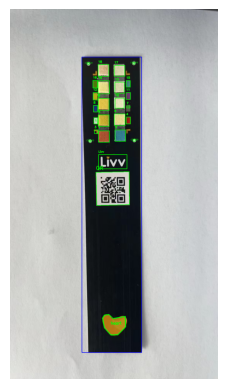

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an input image
image = cv2.imread('ppic.jpg')


# Define color ranges for orange and cyan (in HSV format)
lower_orange = np.array([5, 100, 100], dtype="uint8")
upper_orange = np.array([15, 255, 255], dtype="uint8")

lower_cyan = np.array([85, 80, 80], dtype="uint8")
upper_cyan = np.array([135, 255, 255], dtype="uint8")

# Define the purple color range in HSV format
lower_purple = np.array([130, 50, 50], dtype="uint8")
upper_purple = np.array([160, 255, 255], dtype="uint8")

lower_red = np.array([0, 120, 70], dtype="uint8")
upper_red = np.array([10, 255, 255], dtype="uint8")

# Define the color range for dark green in HSV
lower_dark_green = np.array([40, 40, 40], dtype="uint8")
upper_dark_green = np.array([80, 255, 255], dtype="uint8")

# Define yellow ranges (in HSV)
lower_yellow = np.array([17, 38, 169], dtype="uint8")
upper_yellow = np.array([30, 255, 255], dtype="uint8")

# Define another yellow range
lower_yellow_2 = np.array([31, 100, 100], dtype="uint8")
upper_yellow_2 = np.array([35, 255, 255], dtype="uint8")

lower_white = np.array([0, 0, 200], dtype="uint8")
upper_white = np.array([180, 25, 255], dtype="uint8")

# Convert the target RGB to HSV
target_rgb = [83, 84, 80]   # Target RGB color
target_rgb_bgr = [target_rgb[2], target_rgb[1], target_rgb[0]]  # Convert RGB to BGR as OpenCV uses BGR format
target_hsv = cv2.cvtColor(np.uint8([[target_rgb_bgr]]), cv2.COLOR_BGR2HSV)[0][0]

# Define a narrow range around the target HSV value
lower_target_hsv = np.array([target_hsv[0] - 10, 50, 50], dtype="uint8")
upper_target_hsv = np.array([target_hsv[0] + 10, 255, 255], dtype="uint8")

# Add all color ranges to detect
color_ranges = [
    (lower_orange, upper_orange),   # Orange range
    (lower_cyan, upper_cyan),       # Cyan range
    (lower_purple, upper_purple),   # Purple range
    (lower_red, upper_red),         # Lower red range
    (lower_dark_green, upper_dark_green),  # Dark green range
    (lower_yellow, upper_yellow),   # First yellow range
    (lower_yellow_2, upper_yellow_2), # Second yellow range
    (lower_target_hsv, upper_target_hsv),  # Target HSV range for the specific RGB color
]

# Initialize the last valid contour index (set this appropriately based on previous usage)
last_valid_contour_index = 0


# Step 1: Detect the heart and contour it
final_image_with_heart, heart_contour = detect_heart_and_contour(image)

# Step 1: Call the detect_colored_regions function FIRST
final_image_with_colored_regions, colored_contours = detect_colored_regions(image, color_ranges, last_valid_contour_index + 1)

# Step 2

# Step 2: Detect black rectangles
final_image_with_black_rectangles, black_rectangles = detect_black_rectangles(final_image_with_colored_regions)

# Step 3: Use the contours from colored regions to create a mask for text detection
mask_for_text = np.zeros(image.shape[:2], dtype="uint8")
cv2.drawContours(mask_for_text, colored_contours, -1, (255), thickness=cv2.FILLED)

# Step 4: Call the detect_text_and_draw_boxes function, excluding colored regions
final_image_with_text = detect_text_and_draw_boxes(final_image_with_black_rectangles, black_rectangles, mask_for_text)

# Step 5: Detect QR code
final_image_with_black_rectangles, qr_code_contour = detect_qr_code_manually(final_image_with_black_rectangles)

# Step 6: Call detect_selected_contours for specific shape selection
min_rectangle_area = 100
aspect_ratio_range = (0.3, 0.9)  # Rectangle-like shapes
final_image_with_black_rectangles, selected_contours = detect_selected_contours(final_image_with_text, last_valid_contour_index + 1, min_area=min_rectangle_area, target_aspect_ratio_range=aspect_ratio_range)

# Step 7: Detect white circles in black boxes
final_image_with_circles = detect_white_circles_in_black_boxes(final_image_with_black_rectangles, black_rectangles)

# Save the final processed image
cv2.imwrite('output_combined.jpg', final_image_with_black_rectangles)

# Display the final image with detected regions
plt.imshow(cv2.cvtColor(final_image_with_black_rectangles, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()